In [354]:
#Conversion rate: the purpose is to understand what contributes to conversion and how to improve conversion rate based on the collected data.
#This solution explore various data sampling techniques upon the highly imbalanced dataset, all of which have been feeded to machine learning algorithms for training and test.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalanceCascade, EasyEnsemble
from scipy.stats import skew
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, auc, roc_curve, confusion_matrix, precision_recall_fscore_support
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#import data
data = pd.read_csv('conversion_data.csv')

In [356]:
#Skin through the data
data.shape #(316200, 6)
data.sample(5)

,country,age,new_user,source,total_pages_visited,converted
98129,US,23,0,Seo,2,0
228822,US,27,0,Seo,7,0
177237,US,24,1,Direct,6,0
299983,UK,44,0,Ads,2,0
257374,US,40,0,Seo,1,0


In [357]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


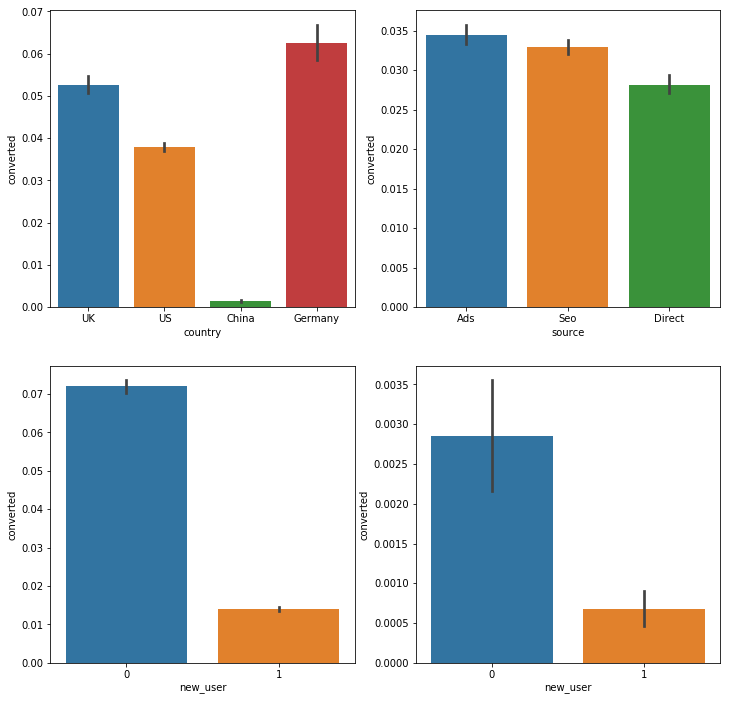

In [359]:
#EDA: visualization by plotting features with conversion
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.barplot(x='country', y='converted', data=data, ax=ax[0][0])
sns.barplot(x='source', y='converted', data=data, ax=ax[0][1])
sns.barplot(x='new_user', y='converted', data=data, ax=ax[1][0])
sns.barplot(x='new_user', y='converted', data=data[data.country=='China'], ax=ax[1][1])

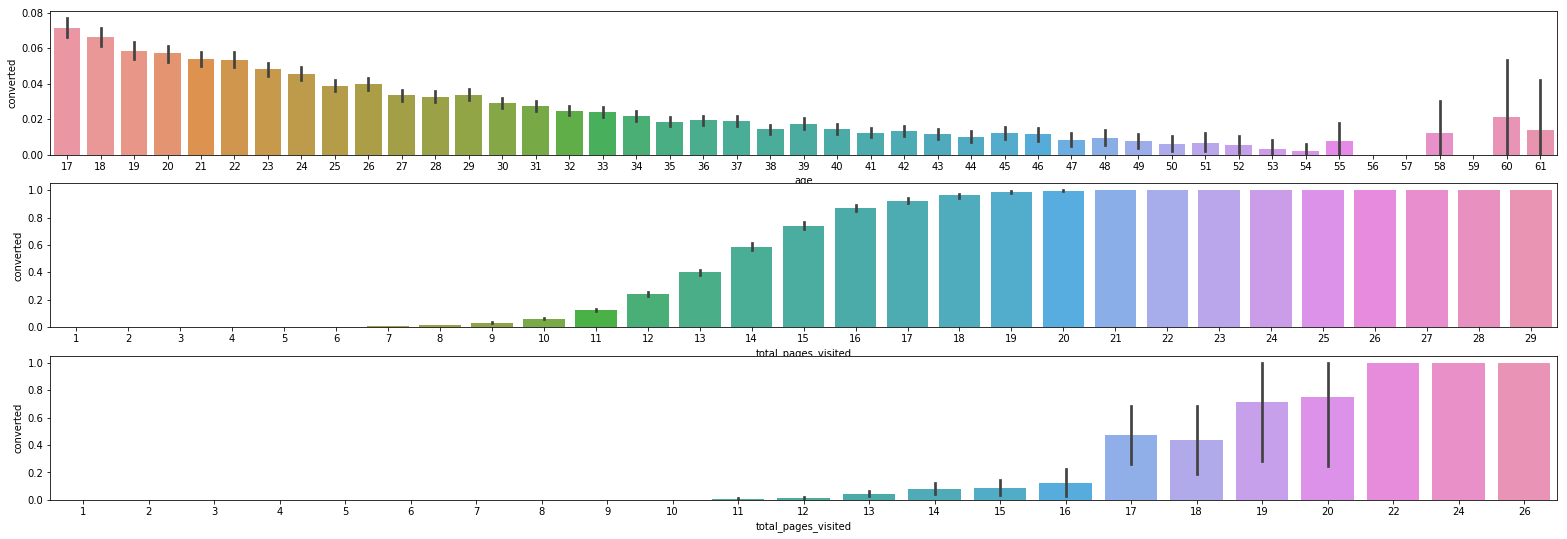

In [361]:
#EDA: more visualization
fig, ax = plt.subplots(3,1,figsize=(27,12))
data=data[data.age<62] #2 data points with age over 110, not very likely, delete them
sns.barplot(x='age', y='converted',data=data, ax=ax[0])
sns.barplot(x='total_pages_visited', y='converted', data=data, ax=ax[1])
sns.barplot(x='total_pages_visited', y='converted', data=data[data.country=='China'], ax=ax[2])

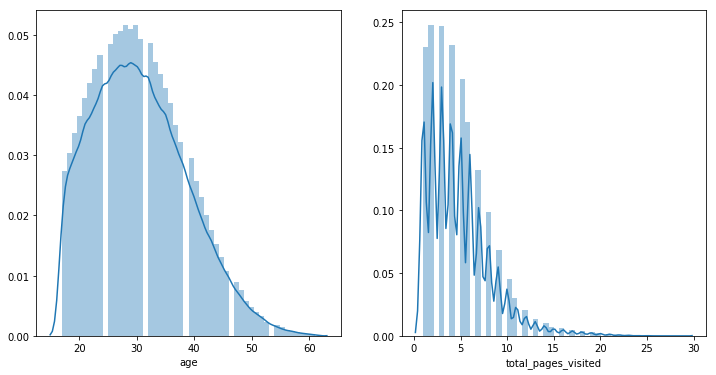

In [367]:
#EDA: data distribution
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.distplot(data['age'], ax=ax[0])
sns.distplot(data['total_pages_visited'], ax=ax[1])

In [245]:
#Data preprocessing#
#According to data describe, generally very clean data, no missing values, 'age' has abnormal large value, 'converted' mean is 0.03 (likely imblanced).

data.isnull().sum() #none, no data impute required.

#1. clean age data
data=data[data.age<80] #2 data points with age over 110, not very likely, delete them.

#2. check magnitude of data imbalance
pd.value_counts(data['converted'], sort=True).sort_index() #0: 305836; 1: 10198 (~3%). 
##Very imbalanced, will try sampling techniques to get it balanced.

#3. reduce skewness of numeric features
nemeric_features = ['age', 'total_pages_visited']
skewness = data[numeric_featues].apply(lambda x: skew(x.dropna()))  #age: 0.4903, total_pages_visited: 1.44289

data['age'] = np.log1p(data['age']) #original data not highly skewed but reduced to -0.0529 after transformation.
data['total_pages_visited'] = np.log1p(data['total_pages_visited']) #to reduce skewness to -0.015 (not improvement in modeling by clip[1,21])

#4. transform categorical data
data = pd.get_dummies(data)

#5. Re-organize columns
cols = data.columns.tolist()
cols = cols[:3] + cols[4:] + cols[3:4]
data = data[cols]

In [246]:
#Part 1. Model with all features
#train and test data split

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

test_size = 0.3 #30% data to be assigned as test data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)


In [250]:
##Data sampling: all features

def Sampling(sampler, X, y):           #define a data sampling function
    x_resampled, y_resampled = sampler.fit_sample(X,y)
    return sampler.__class__.__name__, pd.DataFrame(x_resampled), pd.DataFrame(y_resampled)

data_sampling = []
data_sampling.append(('base', x_train, y_train))
data_sampling.append(Sampling(RandomUnderSampler(), x_train, y_train)) #undersampling
data_sampling.append(Sampling(RandomOverSampler(), x_train, y_train)) #oversampling
data_sampling.append(Sampling(SMOTE(n_jobs=-1), x_train, y_train)) #oversampling
data_sampling.append(Sampling(SMOTEENN(n_jobs=-1), x_train, y_train)) #oversampling followed by undersampling
data_sampling.append(Sampling(SMOTETomek(n_jobs=-1), x_train, y_train)) #oversampling followed by undersampling

ee = EasyEnsemble(random_state=0)  #ensemble sampling
ee.fit(x_train, y_train)
x_resampled_ee, y_resampled_ee = ee.sample(x_train, y_train)
x_resampled_ee, y_resampled_ee = x_resampled_ee.reshape(142740,10), y_resampled_ee.reshape(142740)
data_sampling.append(('EasyEnsemble', x_resampled_ee, y_resampled_ee))

bc=BalanceCascade(estimator=LogisticRegression(), n_max_subset=10, random_state=0) #ensemble sampling
bc.fit(x_train, y_train)
x_resampled_bc, y_resampled_bc = bc.sample(x_train, y_train)
x_resampled_bc, y_resampled_bc = x_resampled_bc.reshape(142740,10), y_resampled_bc.reshape(142740)
data_sampling.append(('BalanceCascade', x_resampled_bc, y_resampled_bc))

/Users/renjia/anaconda2/lib/python2.7/site-packages/imblearn/combine/smote_enn.py:224: DeprecationWarning: Parameters initialization will be replaced in version 0.4. Use a SMOTE object instead.
  DeprecationWarning)
/Users/renjia/anaconda2/lib/python2.7/site-packages/imblearn/combine/smote_enn.py:251: DeprecationWarning: Parameters initialization will be replaced in version 0.4. Use a ENN object instead.
  DeprecationWarning)
/Users/renjia/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/Users/renjia/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)
/Users/renjia/anaconda2/lib/python2.7/site-packages/imblearn/combine/smote_tomek.py:174: DeprecationWarning: Parameters initializati

In [ ]:
#Modeling
#Modeling by Random Forest

rf_scores = []
plt.plot(figsize=(8,8))
plt.plot([0,1],[0,1],linestyle='--', color='k')
plt.title('Receiver Operating Characteristics: RandomForest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
for s, X, y in data_sampling:
    rfc = RandomForestClassifier(max_features='log2', max_depth=3, n_estimators=1000, min_samples_split=2, 
                                 oob_score=False, n_jobs=4, verbose=1, random_state=0)
#     params = {'max_features': ['log2', 'sqrt'], 'max_depth': [3,5], 'n_estimators': [100,1000], 
#               'min_samples_split': [2,3]}
#     rfc = GridSearchCV(rfc, params, scoring='accuracy', cv=3, n_jobs=4)
    X = pd.DataFrame(X)
    rfc.fit(X.values, y)
    y_hat_rfc = rfc.predict(x_test.values)
    y_hat_rfc_proba = rfc.predict_proba(x_test.values)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, y_hat_rfc_proba)
    rf_scores.append((s,
                     precision_score(y_test, y_hat_rfc),
                     recall_score(y_test, y_hat_rfc),
                     f1_score(y_test, y_hat_rfc),
                     accuracy_score(y_test, y_hat_rfc),
                     auc(fpr, tpr),
                     confusion_matrix(y_test, y_hat_rfc)))
    plt.plot(fpr, tpr, label=s + ': AUC= %.4f'%auc(fpr, tpr))
    plt.legend(loc='lower right') 
    
rf_scores = pd.DataFrame(rf_scores, columns=['sampling', 'precision', 'recall', 'f1', 'accuracy', 'auc', 'confusion_matrix'])

#Modeling by XGBoost
xgb_scores = []
plt.plot(figsize=(8,8))
plt.plot([0,1],[0,1],linestyle='--', color='k')
plt.title('Receiver Operating Characteristics: XGBoost')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
for s, X, y in data_sampling:
    xgbc = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, objective='binary:logistic',
                             booster='gbtree', n_jobs=4, verbose=1, random_state=0)
#     params = {'max_depth': [3,5], 'learning_rate': [0.05,0.1], 'n_estimators': [100,500], 'objective': ['binary:logistic'],
#              'booster':['gbtree']}
#     xgbc = GridSearchCV(xgbc, params, n_jobs=4, verbose=1)
    X = pd.DataFrame(X)
    xgbc.fit(X.values,y.values.ravel())
    y_hat_xgb = xgbc.predict(x_test.values)
    y_hat_xgb_proba = xgbc.predict_proba(x_test.values)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_hat_xgb_proba)
    xgb_scores.append((xgbc.__class__.__name__,
                      s,
                      precision_score(y_test, y_hat_xgb),
                      recall_score(y_test, y_hat_xgb),
                      f1_score(y_test, y_hat_xgb),
                      accuracy_score(y_test, y_hat_xgb),
                      auc(fpr, tpr),
                      confusion_matrix(y_test, y_hat_xgb)))
    plt.plot(fpr, tpr, label=s + ': AUC= %.4f'%auc(fpr, tpr))
    plt.legend(loc='lower right') 
xgb_scores = pd.DataFrame(xgb_scores, columns=['model', 'sampling', 'precision', 'recall', 'f1', 'accuracy', 'auc', 'confusion_matrix'])

scores = pd.concat([rf_scores, xgb_scores], axis=0)
scores

In [264]:
#Output feature importance from various models

feature_importance_rf = rfc.feature_importances_/rfc.feature_importances_.max()
feature_importance_xgb = xgbc.feature_importances_/xgbc.feature_importances_.max()
feature_importance = pd.DataFrame({'feature': x_train.columns.tolist(),'RandomForest': feature_importance_rf,
                                   'XGBoost': feature_importance_xgb}).sort_values('XGBoost', ascending=False)
feature_importance

,LogisticRegression,RandomForest,XGBoost,feature
2,0.794712,1.000000,1.000000,total_pages_visited
1,0.155522,0.046934,0.352273,new_user
0,0.199915,0.142404,0.298295,age
3,1.000000,0.025150,0.196023,country_China
6,0.719877,0.004739,0.031250,country_US
8,0.661246,0.003327,0.017045,source_Direct
5,0.687546,0.004704,0.014205,country_UK
4,0.672199,0.003099,0.008523,country_Germany
7,0.642570,0.003268,0.005682,source_Ads
9,0.647783,0.003408,0.000000,source_Seo


In [ ]:
#Summary on modeling results from Part 1

#1. Effect of data sampling.
## In general, base data results in the most balanced precision (>50% btter than others) and recall with the best precison, f1 score and accuracy score (>98.5%, and above 97% by just guessing test results of 0).
## The auc from base is also among the best predicted from all 3 ML algorithms. However, sampling data result in much improved recall compared to that from base. Depending on whether the business model of the preference in either minimizing false positve
## or false negative or both, base or sampling data can be chosen to fullfil the purpose.

#2.Feature importances. 
## Both algorithms give high importance to 'total_pages_visited', which is expected, since people who are interested in the website service will visit more pages to understand its details, fill out the required personal info, etc.
## RF: no other features show importance comparable to 'total_pages_visited'.
## XGBoost: 'new_user', 'age' and 'country_China' show significant importance.
## Country importance generally follows a reverse linear relationship, eg. higher conversion rate, less important.
## Access sources are irrelevant.
## What if we remove 'total_pages_visited'?

#3.About the model metrics.
## Due to imbalanced nature of the data, accuracy is not the best metrics to quantify the model performance. auc could be a better choice due to its independence of prediction probability.
## However, if a particular purpose was known, say, the business wants to catch every possible conversion, then false negative is desired to be minimized.
## As such, recall is more important than precision. Thus, sampling is a great approach to be used as all of them improve recall dramatically.

#4.Suggestions to improving conversion rate.
## 4.1 As mentioned, 'total_pages_visited' has intrinsic correlation with conversion. More pages visiting very likely because people have decided to converting. Promoting more page visits may or may not result in higher conversion rate. 
## An A/B test can be designed to promoting pages visit to a group of web-visitors while the other group without any promotion. The two groups should have almost idential distribution in term of country, age, and new_user population.
## 4.2 About China: China has much lower conversion rate compared to the remaining countries, though it has generally similar distributions in age and new_user population and source.
## This is likely western world based websites. Is there a promotion difference b/t western world and Chin##a? Or cultural difference b/t China and western world contributing to the conversion? Or translation inaccuracy? Or a strong competitor locally in China?
## There are huge room to improving conversion rate in China.
## 4.3 About age: young age typically has higher conversion rate. Thus, in the next promotion, targeting young population could result in higher conversion rate. In addition, it is necessary to ask why the service attracks more young people but not the older? Is it because of service nature or others?
## Again, there are also large room to improving conversion rate by even leveling off all ages to the young class.
## 4.4 About new_user: new_user has much lower conversion rate. By screening out their characteristics (such as young age, from western world, having several pages visited), targeting new_user (eg. by promotion or sending reminding messages) may result in revisiting by new_users and thus have the conversion.


In [ ]:
####Part 2. Modeling without the feature 'total_pages_visited'.####

#data sampling
Xt = data.iloc[:, :-1].drop('total_pages_visited', axis=1)
yt = data.iloc[:, -1]
xt_train, xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=test_size, random_state=1)

data_sampling_t = []
data_sampling_t.append(('base', xt_train, yt_train))
data_sampling_t.append(Sampling(RandomUnderSampler(), xt_train, yt_train)) #undersampling
data_sampling_t.append(Sampling(RandomOverSampler(), xt_train, yt_train)) #oversampling
data_sampling_t.append(Sampling(SMOTE(n_jobs=-1), xt_train, yt_train)) #oversampling
data_sampling_t.append(Sampling(SMOTEENN(n_jobs=-1), xt_train, yt_train)) #oversampling followed by undersampling
data_sampling_t.append(Sampling(SMOTETomek(n_jobs=-1), xt_train, yt_train)) #oversampling followed by undersampling

ee = EasyEnsemble(random_state=0)  #ensemble sampling
ee.fit(xt_train, yt_train)
xt_resampled_ee, yt_resampled_ee = ee.sample(xt_train, yt_train)
xt_resampled_ee, yt_resampled_ee = xt_resampled_ee.reshape(142740,9), yt_resampled_ee.reshape(142740)
data_sampling_t.append(('EasyEnsemble', xt_resampled_ee, yt_resampled_ee))

bc=BalanceCascade(estimator=LogisticRegression(), n_max_subset=10, random_state=0) #ensemble sampling
bc.fit(xt_train, yt_train)
xt_resampled_bc, yt_resampled_bc = bc.sample(xt_train, yt_train)
xt_resampled_bc, yt_resampled_bc = xt_resampled_bc.reshape(142740,9), yt_resampled_bc.reshape(142740)
data_sampling_t.append(('BalanceCascade', xt_resampled_bc, yt_resampled_bc))

#modeling

#Random Forest
rf_scores_t = []
for s, X, y in data_sampling_t:
    rfc = RandomForestClassifier(max_features='log2', max_depth=3, n_estimators=1000, min_samples_split=2, oob_score=False, n_jobs=4, random_state=1)
#     params = {'max_features': ['log2', 'sqrt'], 'max_depth': [3,5], 'n_estimators': [100,1000], 
#               'min_samples_split': [2,3]}
#     rfc = GridSearchCV(rfc, params, scoring='accuracy', cv=3, n_jobs=4)
    X = pd.DataFrame(X)
    rfc.fit(X.values, y)
    y_hat_rfc = rfc.predict(xt_test.values)
    y_hat_rfc_proba = rfc.predict_proba(xt_test.values)[:, 1]
    fpr, tpr, threshold = roc_curve(yt_test, y_hat_rfc_proba)
    rf_scores_t.append((rfc.__class__.__name__,
                     s,
                     precision_score(yt_test, y_hat_rfc),
                     recall_score(yt_test, y_hat_rfc),
                     f1_score(yt_test, y_hat_rfc),
                     accuracy_score(yt_test, y_hat_rfc),
                     auc(fpr, tpr),
                     confusion_matrix(y_test, y_hat_rfc)))
rf_scores_t = pd.DataFrame(rf_scores_t, columns=['model', 'sampling', 'precision', 'recall', 'f1', 'accuracy', 'auc', 'confusion_matrix'])

#XGBoost
xgb_scores_t = []
for s, X, y in data_sampling_t:
    xgbc = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, objective='binary:logistic',
                            booster='gbtree', n_jobs=4)
    X = pd.DataFrame(X)
    xgbc.fit(X.values,y)
    y_hat_xgb = xgbc.predict(xt_test.values)
    y_hat_xgb_proba = xgbc.predict_proba(xt_test.values)[:,1]
    fpr, tpr, thresholds = roc_curve(yt_test, y_hat_xgb_proba)
    xgb_scores_t.append((xgbc.__class__.__name__,
                      s,
                      precision_score(yt_test, y_hat_xgb),
                      recall_score(yt_test, y_hat_xgb),
                      f1_score(yt_test, y_hat_xgb),
                      accuracy_score(yt_test, y_hat_xgb),
                      auc(fpr, tpr),
                      confusion_matrix(yt_test, y_hat_xgb)))

xgb_scores_t = pd.DataFrame(xgb_scores_t, columns=['model', 'sampling', 'precision', 'recall', 'f1', 'accuracy', 'auc', 'confusion_matrix'])
xgb_scores_t = xgb_scores_t.reindex(xgb_index)

##Output scores and feature importance

scores_t = pd.concat([rf_scores_t, xgb_scores_t], axis=0)

feature_importance_rf = rfc.feature_importances_/rfc.feature_importances_.max()
feature_importance_xgb = xgbc.feature_importances_/xgbc.feature_importances_.max()
feature_importance_t = pd.DataFrame({'feature': xt_train.columns.tolist(), 'RandomForest': feature_importance_rf,
                                   'XGBoost': feature_importance_xgb}).sort_values('XGBoost', ascending=False)

scores_t
feature_importance_t

In [333]:
scores_t = pd.concat([lr_scores_t, rf_scores_t, xgb_scores_t], axis=0)
scores_t

,model,sampling,precision,recall,f1,accuracy,auc,confusion_matrix
0,LogisticRegression,base,0.000000,0.000000,0.000000,0.967731,0.819680,"[[91799, 0], [3061, 0]]"
1,LogisticRegression,RandomUnderSampler,0.082858,0.759882,0.149423,0.720841,0.819734,"[[66053, 25746], [735, 2326]]"
2,LogisticRegression,RandomOverSampler,0.083271,0.758576,0.150068,0.722728,0.819688,"[[66236, 25563], [739, 2322]]"
3,LogisticRegression,SMOTE,0.083271,0.758576,0.150068,0.722728,0.819659,"[[66236, 25563], [739, 2322]]"
4,LogisticRegression,SMOTEENN,0.102376,0.520745,0.171113,0.837202,0.787422,"[[77823, 13976], [1467, 1594]]"
5,LogisticRegression,SMOTETomek,0.083286,0.758576,0.150092,0.722781,0.819663,"[[66241, 25558], [739, 2322]]"
6,LogisticRegression,EasyEnsemble,0.083271,0.758576,0.150068,0.722728,0.819729,"[[66236, 25563], [739, 2322]]"
7,LogisticRegression,BalanceCascade,0.083790,0.754982,0.150839,0.725701,0.819823,"[[66529, 25270], [750, 2311]]"
0,RandomForestClassifier,base,0.000000,0.000000,0.000000,0.967731,0.815307,"[[91799, 0], [3061, 0]]"
1,RandomForestClassifier,RandomUnderSampler,0.129054,0.492649,0.204530,0.876344,0.816787,"[[81622, 10177], [1553, 1508]]"


In [ ]:
#Summary on part 2 (without total_pages_converted)

# ML algorithms are not able to predict any conversion with base data by removing feature 'total_pages_converte'.
## Though there are >25% false positives, data with sampling improve ML prediction significantly. However,such high fp will cost the business heavily with challenged return from tp.
## Thus, for such problem, eliminating strong feature results in poor performance of machine learning algorithms that should be avoided.

#In brief, sampling is useful in perspective of improving either precision or recall, but it is the strong feature(s) mattering the most for machine learning algorithm to learn and then to predict.


In [ ]:
#####Sampling reference
# NearMiss - "kNN approach to unbalanced data distributions: A case study involving information extraction", by Zhang et al., 2003.
# CNN - "Addressing the Curse of Imbalanced Training Sets: One-Sided Selection", by Kubat et al., 1997.
# One-Sided Selection - "Addressing the Curse of Imbalanced Training Sets: One-Sided Selection", by Kubat et al., 1997.
# NCL - "Improving identification of difficult small classes by balancing class distribution", by Laurikkala et al., 2001.
# SMOTE - "SMOTE: synthetic minority over-sampling technique", by Chawla et al., 2002.
# Borderline SMOTE - "Borderline-SMOTE: A New Over-Sampling Method in Imbalanced Data Sets Learning", by Han et al., 2005
# SVM_SMOTE - "Borderline Over-sampling for Imbalanced Data Classification", Nguyen et al., 2011.
# SMOTE + Tomek - "Balancing training data for automated annotation of keywords: a case study", Batista et al., 2003.
# SMOTE + ENN - "A study of the behavior of several methods for balancing machine learning training data", Batista et al., 2004.
# EasyEnsemble & BalanceCascade - "Exploratory Understanding for Class-Imbalance Learning", by Liu et al., 2009.